In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()
words

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [5]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [7]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),               generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator = g) * (5/3)/((n_embd * block_size ** 0.5))
b1 = torch.randn(n_hidden,                          generator = g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),            generator = g) * 0.1
b2 = torch.randn(vocab_size,                        generator = g) * 0.1

bngain = torch.randn((1, n_hidden)) * 0.1 + 1
bnbias = torch.randn((1, n_hidden)) * 0.1
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f"{sum(p.nelement() for p in parameters)} parameters")

for p in parameters:
    p.requires_grad = True

12297 parameters


In [8]:
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [9]:
# x = torch.randn(1000, 10)
# w = torch.randn(10, 200) / (10**0.5)
# y = x @ w
# print(x.mean(), x.std())
# print(y.mean(), y.std())
# plt.figure(figsize=(20, 5))
# plt.subplot(121)
# plt.hist(x.view(-1).tolist(), 50, density = True)
# plt.subplot(122)
# plt.hist(y.view(-1).tolist(), 50, density = True)

In [222]:
# lri = []
# stepi = []

In [10]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
hprebn = embcat @ W1 + b1
bnmeani = 1/n*hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim = True)
bnvar_inv = (bnvar + 1E-5)**-0.5
bnraw = bndiff*bnvar_inv
hpreact = bngain * bnraw + bnbias
h=torch.tanh(hpreact)
logits = h @ W2 + b2
logit_maxes = logits.max(1, keepdim = True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims = True)
counts_sum_inv = counts_sum**-1
probs = counts*counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, 
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, hprebn, bnmeani,
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.8260, grad_fn=<NegBackward0>)

In [17]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1/n
dprobs = (1/probs)*dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim = True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('probs', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum_inv, counts_sum_inv)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [224]:
# max_steps = 200000
# batch_size = 32
# lossi = []

# for i in range(max_steps):
#     ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
#     Xb, Yb = Xtr[ix], Ytr[ix]

#     emb = C[Xb]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
#     bnmeani = hpreact.mean(0, keepdim = True)
#     bnstdi = hpreact.std(0, keepdim = True)
#     hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

#     with torch.no_grad():
#         bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
#         bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

#     h = torch.tanh(hpreact)
#     logits = h @ W2 + b2
#     loss = F.cross_entropy(logits, Yb)
#     # print(f"Loss {loss.item()} for epoch {_} -----")

#     for p in parameters:
#         p.grad = None
#     loss.backward()

#     # lr = lrs[i]
#     lr = 0.1 if i < 100000 else 0.01
#     for p in parameters:
#         p.data += -lr * p.grad

#     # lri.append(lre[i])
#     if i % 10000 == 0:
#         print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
#     lossi.append(loss.log10().item())
    

      0/ 200000: 3.3014
  10000/ 200000: 2.4702
  20000/ 200000: 2.3136
  30000/ 200000: 2.0670
  40000/ 200000: 1.9662
  50000/ 200000: 2.3548
  60000/ 200000: 2.2449
  70000/ 200000: 2.1140
  80000/ 200000: 2.0604
  90000/ 200000: 2.0481
 100000/ 200000: 2.4419
 110000/ 200000: 2.0270
 120000/ 200000: 2.1811
 130000/ 200000: 2.3383
 140000/ 200000: 2.2106
 150000/ 200000: 2.2789
 160000/ 200000: 2.2036
 170000/ 200000: 2.0866
 180000/ 200000: 2.2886
 190000/ 200000: 1.9594


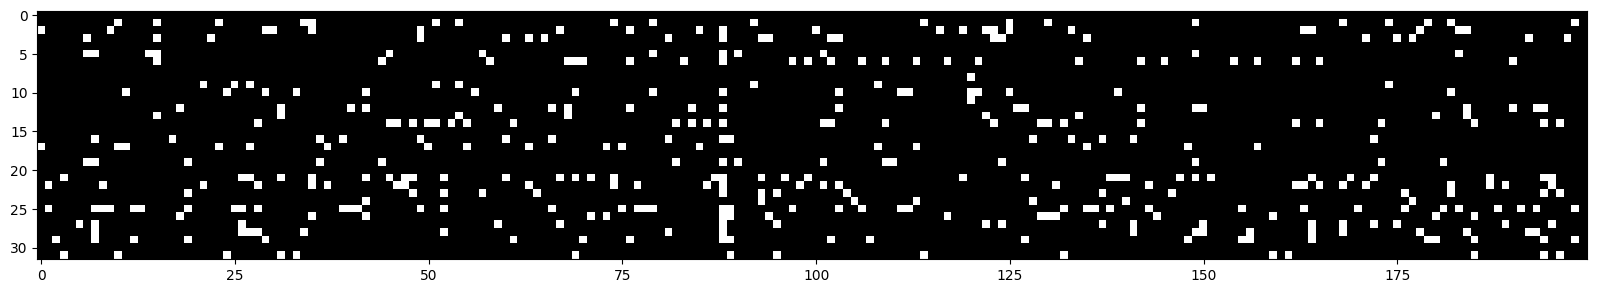

In [225]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap ='gray', interpolation = 'nearest')

(array([513., 253., 176., 168., 124., 104., 111.,  98.,  74., 112.,  88.,
        110.,  74.,  93., 100., 109., 103., 100.,  77., 100., 107., 124.,
         75., 103., 115.,  88., 118., 125., 131., 102.,  93., 109., 112.,
        113.,  80.,  98.,  99.,  70.,  84., 117.,  90.,  87.,  90., 108.,
        114., 135., 129., 192., 243., 462.]),
 array([-1.00000000e+00, -9.60001459e-01, -9.20002918e-01, -8.80004377e-01,
        -8.40005836e-01, -8.00007296e-01, -7.60008755e-01, -7.20010214e-01,
        -6.80011673e-01, -6.40013132e-01, -6.00014591e-01, -5.60016050e-01,
        -5.20017509e-01, -4.80018969e-01, -4.40020428e-01, -4.00021887e-01,
        -3.60023346e-01, -3.20024805e-01, -2.80026264e-01, -2.40027723e-01,
        -2.00029182e-01, -1.60030642e-01, -1.20032101e-01, -8.00335598e-02,
        -4.00350189e-02, -3.64780426e-05,  3.99620628e-02,  7.99606037e-02,
         1.19959145e-01,  1.59957685e-01,  1.99956226e-01,  2.39954767e-01,
         2.79953308e-01,  3.19951849e-01,  3.59950

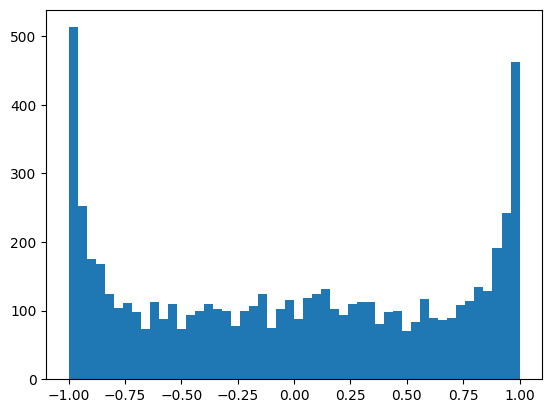

In [226]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   2.,   6.,  15.,  16.,  13.,  27.,  36.,  58.,
         89., 108., 119., 189., 220., 291., 312., 435., 571., 698., 756.,
        570., 423., 324., 262., 233., 174., 110., 109.,  71.,  54.,  39.,
         31.,  14.,  13.,   2.,   5.,   2.]),
 array([-9.09351158e+00, -8.80945436e+00, -8.52539713e+00, -8.24133990e+00,
        -7.95728268e+00, -7.67322545e+00, -7.38916822e+00, -7.10511100e+00,
        -6.82105377e+00, -6.53699655e+00, -6.25293932e+00, -5.96888209e+00,
        -5.68482487e+00, -5.40076764e+00, -5.11671041e+00, -4.83265319e+00,
        -4.54859596e+00, -4.26453874e+00, -3.98048151e+00, -3.69642428e+00,
        -3.41236706e+00, -3.12830983e+00, -2.84425261e+00, -2.56019538e+00,
        -2.27613815e+00, -1.99208093e+00, -1.70802370e+00, -1.42396647e+00,
        -1.13990925e+00, -8.55852022e-01, -5.71794796e-01, -2.87737570e-01,
        -3.68034363e-03,  2.80376883e-01,  5.64434

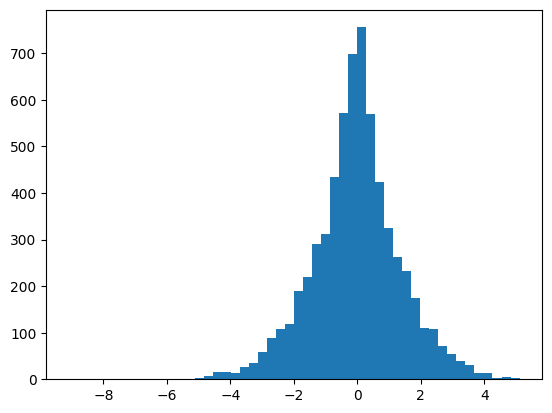

In [227]:
plt.hist(hpreact.view(-1).tolist(), 50)

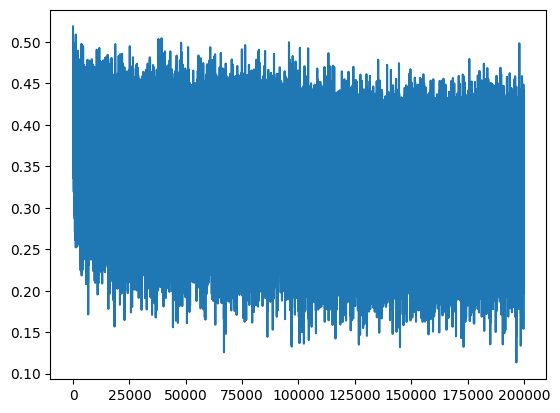

In [228]:
plt.plot(lossi)

In [229]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

In [230]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim = True)) / hpreact.std(0, keepdim = True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('test')

train 3.0423498153686523
test 3.08451509475708


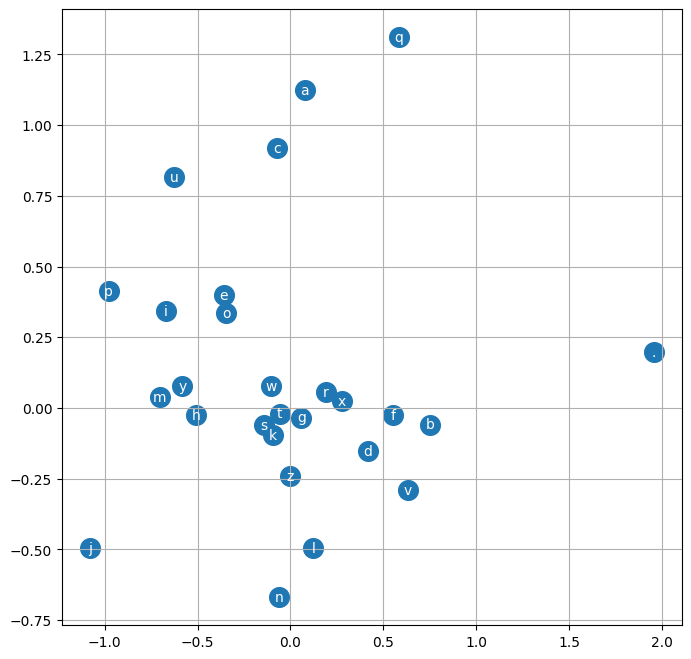

In [161]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [162]:
###CREATE WORDS
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
ambril.
khirilli.
tatyanna.
sane.
mahnen.
deliah.
jaree.
corrisephanaiir.
kaleigh.
ham.
join.
quinton.
lilea.
jamilio.
jerry.
jarynix.
kael.
drudi.
emmedo.


In [244]:
#####

class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g)/ fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True, unbiased = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [264]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd),               generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"{sum(p.nelement() for p in parameters)} parameters")

for p in parameters:
    p.requires_grad = True

54924 parameters


In [259]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lre[i])
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i > 1000:
        break

      0/ 200000: 2.8261


Layer 1 (      Tanh): mean -0.02, std 0.65, saturated: 5.97%
Layer 3 (      Tanh): mean +0.01, std 0.59, saturated: 1.25%
Layer 5 (      Tanh): mean +0.01, std 0.59, saturated: 1.88%
Layer 7 (      Tanh): mean -0.02, std 0.59, saturated: 2.16%
Layer 9 (      Tanh): mean -0.01, std 0.56, saturated: 0.88%


Text(0.5, 1.0, 'Act Dist')

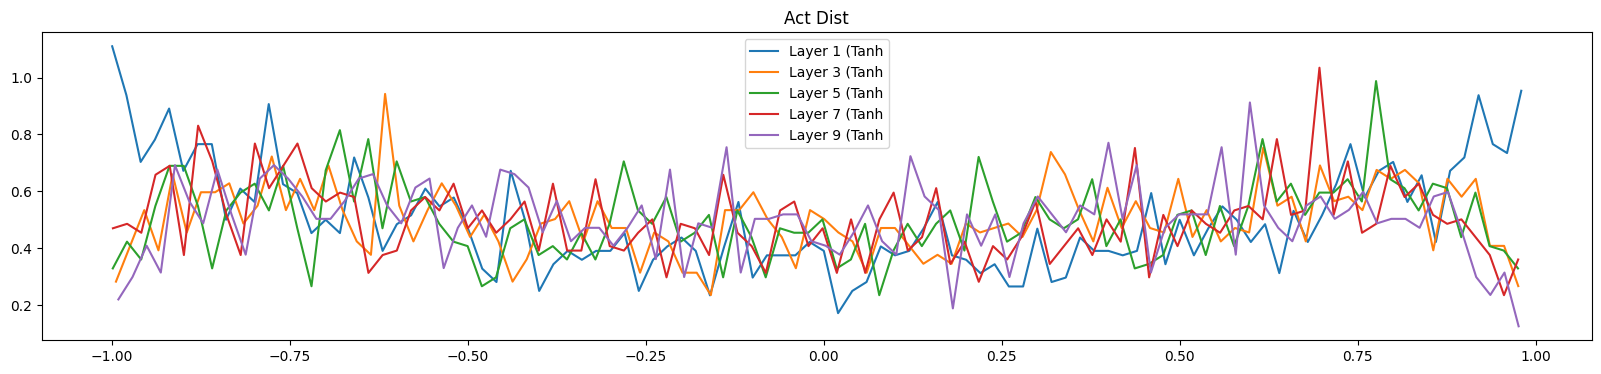

In [260]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print("Layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__}")
plt.legend(legends)
plt.title("Act Dist")

Weight   (27, 10) | mean +0.000422 | std 7.196277e-03 | grad:data ratio 7.088934e-03
Weight  (30, 100) | mean -0.000141 | std 7.577342e-03 | grad:data ratio 3.827163e-02
Weight (100, 100) | mean +0.000018 | std 5.017664e-03 | grad:data ratio 4.679381e-02
Weight (100, 100) | mean +0.000004 | std 4.388914e-03 | grad:data ratio 4.121090e-02
Weight (100, 100) | mean -0.000007 | std 4.409946e-03 | grad:data ratio 4.187169e-02
Weight (100, 100) | mean -0.000009 | std 4.366978e-03 | grad:data ratio 4.206572e-02
Weight  (100, 27) | mean -0.000000 | std 1.639967e-02 | grad:data ratio 2.192017e-01


Text(0.5, 1.0, 'Act Dist')

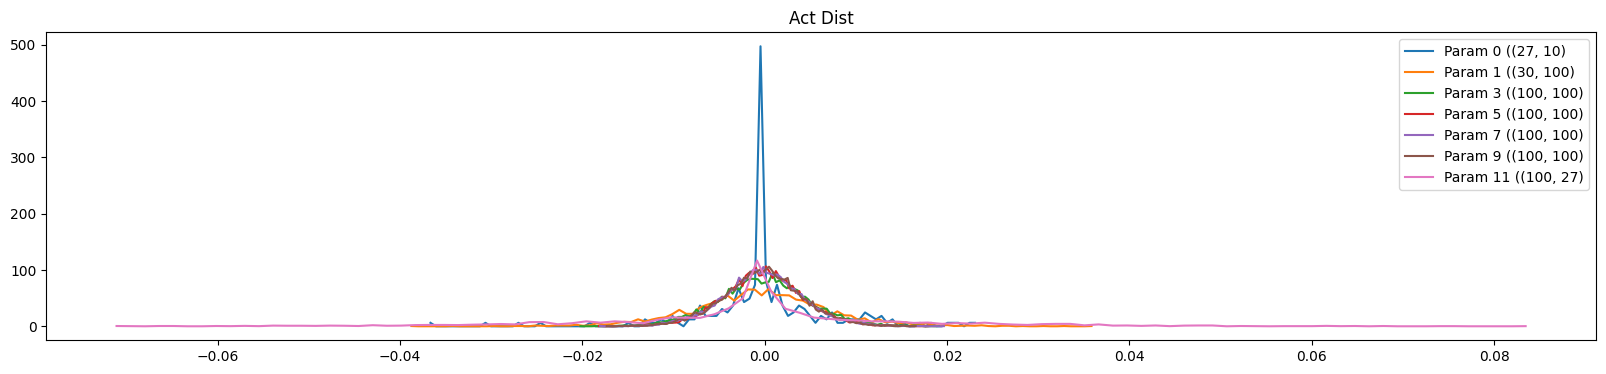

In [261]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        
        print("Weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Param {i} ({tuple(p.shape)}")
plt.legend(legends)
plt.title("Act Dist")

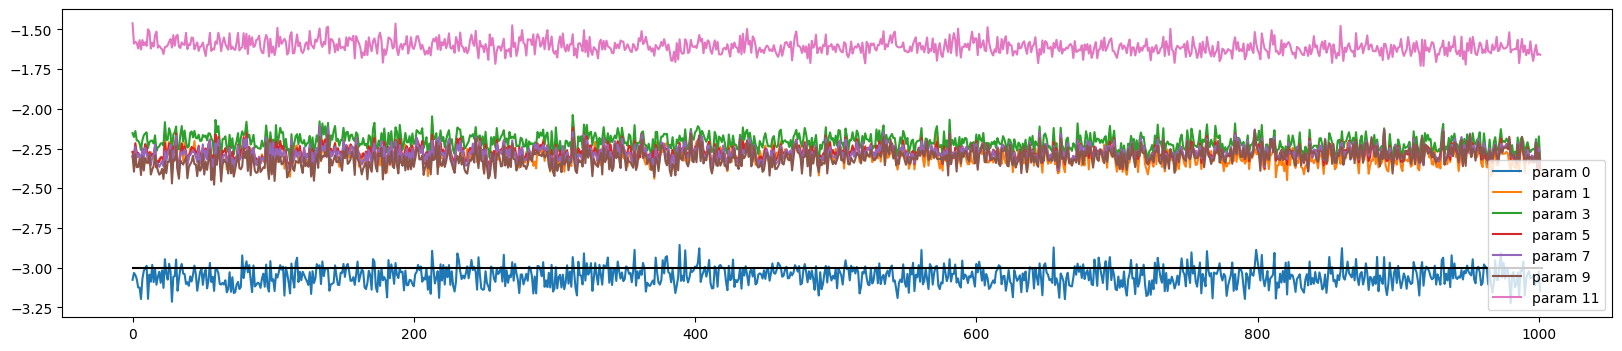

In [262]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)